## Unscented transform

In [1]:
import numpy as np
from scipy import linalg

In [2]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html

m = np.array([12.3, 7.6])
P = np.array([[1.44, 0], [0, 2.89]])

In [3]:
linalg.sqrtm(P)

array([[1.2, 0. ],
       [0. , 1.7]])

In [49]:
L_P = linalg.cholesky(P)
L_P

array([[1.2, 0. ],
       [0. , 1.7]])

In [38]:
alpha = 1.2
beta = 2
kappa = 0

L = 2

lambda_ = alpha**2 * (L + kappa) - L
lambda_, lambda_ + L

(0.8799999999999999, 2.88)

In [39]:
Chi = [0]
Chi += [np.sqrt((L + lambda_)*1.44), np.sqrt((L + lambda_)*2.89)]
Chi += [-np.sqrt((L + lambda_)*1.44), -np.sqrt((L + lambda_)*2.89)]
Chi = np.array([m + w for w in Chi])

W_0m = [lambda_/(L + lambda_)]
W_0m += [1.0 / 2.0 / (L + lambda_)] * 4
W_0c = [lambda_/(L + lambda_) + (1 - alpha**2 + beta)]
W_0c += [1.0 / 2.0 / (L + lambda_)] * 4

W_0m = np.array(W_0m)
W_0c = np.array(W_0c)

In [40]:
Chi, W_0m, W_0c

(array([[12.3       ,  7.6       ],
        [14.33646753,  9.63646753],
        [15.18499567, 10.48499567],
        [10.26353247,  5.56353247],
        [ 9.41500433,  4.71500433]]),
 array([0.30555556, 0.17361111, 0.17361111, 0.17361111, 0.17361111]),
 array([1.86555556, 0.17361111, 0.17361111, 0.17361111, 0.17361111]))

The transformation function to polar coordinates,

\begin{align}
r &= \sqrt{x^2 + y^2} \\
\theta &= \arctan{ \frac{y}{x} }
\end{align}

In [41]:
def transform(xy):
    x, y = xy[0], xy[1]
    return np.sqrt(x**2 + y**2), np.arctan(y / x)

rtheta = np.array(list(map(transform, Chi[:])))
rtheta

array([[14.45856148,  0.5534674 ],
       [17.27413696,  0.59179929],
       [18.45316308,  0.60431076],
       [11.67445897,  0.49673299],
       [10.52965206,  0.46428487]])

In [42]:
rtheta_mean = sum([W_0m[i] * rtheta[i, :] for i in range(5)])
rtheta_mean

array([14.47543043,  0.54361641])

In [43]:
rtheta_del = rtheta - rtheta_mean
rtheta_del

array([[-0.01686895,  0.00985099],
       [ 2.79870653,  0.04818288],
       [ 3.97773265,  0.06069435],
       [-2.80097146, -0.04688342],
       [-3.94577837, -0.07933154]])

In [44]:
sum([W_0c[i] * np.outer(rtheta_del[i,:], rtheta_del[i,:]) for i in range(5)])

array([[8.17235783e+00, 1.42158637e-01],
       [1.42158637e-01, 2.69786723e-03]])

In [45]:
import pandas as pd

In [46]:
df = pd.read_csv('./data/mgdata.csv')
df.head()

,step,value
0,0,1.200000
1,1,1.085805
2,2,0.982477
3,3,0.888982
4,4,0.804384


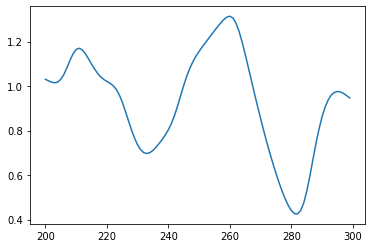

In [48]:
df['value'].iloc[200:300].plot()

In [50]:
from filterpy import kalman

In [51]:
def fx(x, dt):
    F = np.array([
        [1, dt, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, dt],
        [0, 0, 0, 1],
    ], dtype=np.float)
    return np.dot(F, x)

def hx(x):
    return np.array([x[0], x[2]])

In [52]:
dt = 0.1
points = kalman.MerweScaledSigmaPoints(4, alpha=0.1, beta=2.0, kappa=-1.0)
points

MerweScaledSigmaPoints object
n = 4
alpha = 0.1
beta = 2.0
kappa = -1.0
Wm = [-132.33333333   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667]
Wc = [-129.34333333   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667]
subtract = <ufunc 'subtract'>
sqrt = <function cholesky at 0x7f9f1f0245f0>

In [55]:
np.random.randn()

0.2713372923443942

In [56]:
from filterpy.common import Q_discrete_white_noise


kf = kalman.UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([-1, 1.0, -1.0, 1.0])
kf.P *= 0.2
z_std = 0.1
kf.R = np.diag([z_std**2, z_std**2])
kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01**2, block_size=2)
zs = [[i+np.random.randn()*z_std, i+np.random.randn()*z_std] for i in range(50)]
for z in zs:
    kf.predict()
    kf.update(z)
    print(kf.x, 'log-likelihood', kf.log_likelihood)

[-0.03266001  1.08587525  0.18207762  1.1071364 ] log-likelihood -5.28269100698677
[0.53473954 1.89990089 0.67253215 1.7808738 ] log-likelihood -26.12859126038287
[1.28975822 3.60310599 1.35671746 3.30644012] log-likelihood -64.38049328881148
[2.26536946 5.52981534 2.35962585 5.41152169] log-likelihood -94.94523110074631
[3.40206454 7.18032722 3.52890202 7.18760884] log-likelihood -88.96238553211425
[4.41417959 7.90840272 4.63218201 8.13958359] log-likelihood -31.26901878041742
[5.51988955 8.59124461 5.66142428 8.60645886] log-likelihood -22.7636461742188
[6.65175502 9.11391965 6.67485558 8.89925356] log-likelihood -18.200599723212733
[7.71763992 9.37824677 7.72135947 9.16714901] log-likelihood -10.019367313278007
[8.78260825 9.5743612  8.73382366 9.31483877] log-likelihood -5.437734916878038
[9.8637405  9.74787217 9.78250969 9.47924052] log-likelihood -8.28351880549765
[10.954779    9.89729823 10.83738691  9.61671505] log-likelihood -8.414818421683044
[11.96221438  9.91829109 11.88525